<a href="https://colab.research.google.com/github/WerberAlex/E-DOLLYV2/blob/main/Chapter04/CNN_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.2MB/s]


In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [6]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [7]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─MaxPool2d: 1-2                         [-1, 64, 12, 12]          --
├─ReLU: 1-3                              [-1, 64, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           204,928
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 733,706
Trainable params: 733,706
Non-trainable params: 0
Total mult-adds (M): 14.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.80
Estimated Total Size (MB): 

In [10]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4


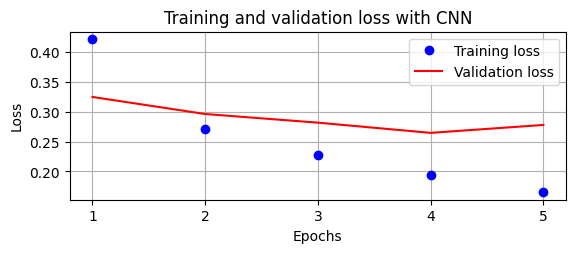

/tmp/ipython-input-821544306.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


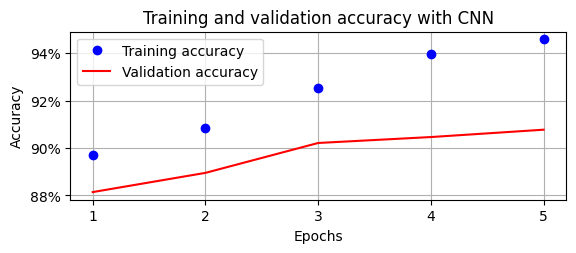

In [11]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

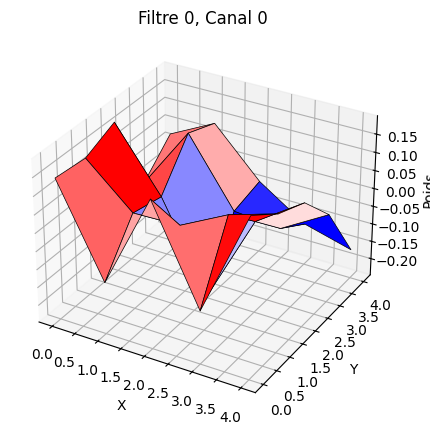

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour 3D
import numpy as np
import torch

def plot_conv_filter_3d(conv_layer, filter_index=0, channel_index=0):
    """
    Affiche un filtre convolutionnel en 3D.

    conv_layer : nn.Conv2d
    filter_index : numéro du filtre à afficher (0 ≤ filter_index < out_channels)
    channel_index : canal du filtre à afficher (0 ≤ channel_index < in_channels)
    """
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]  # shape (kernel_h, kernel_w)

    h, w = filter_weights.shape
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Z = filter_weights

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='bwr', edgecolor='k', linewidth=0.5)
    ax.set_title(f'Filtre {filter_index}, Canal {channel_index}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Poids')
    plt.show()

conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]

plot_conv_filter_3d(conv_layer, filter_index=0, channel_index=0)  # affiche le premier filtre du canal 0


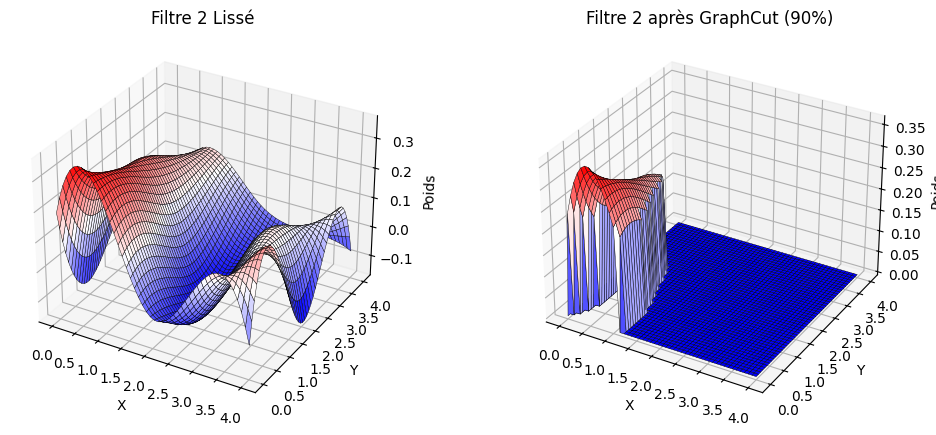

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from scipy.interpolate import RegularGridInterpolator

def graphcut_filter_surface(Zsmooth, percentile=70):
    """
    Simule un GraphCut sur une surface lisse en utilisant un seuil basé sur percentile.
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de poids à conserver
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) >= threshold
    Zcut = Zsmooth * mask
    return Zcut, mask

def plot_conv_surface_with_graphcut(conv_layer, filter_index=0, channel_index=0, smooth_factor=50, percentile=70):
    W = conv_layer.weight.data.cpu().numpy()
    filter_weights = W[filter_index, channel_index]

    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)

    # Interpolation lisse
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)

    # GraphCut simplifié
    Zcut, mask = graphcut_filter_surface(Zsmooth, percentile=percentile)

    # Affichage 3D
    fig = plt.figure(figsize=(12,5))

    # Surface lisse
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Zsmooth, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax1.set_title(f'Filtre {filter_index} Lissé')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Poids')

    # Surface après GraphCut
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, Zcut, cmap='bwr', edgecolor='k', linewidth=0.3)
    ax2.set_title(f'Filtre {filter_index} après GraphCut ({percentile}%)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Poids')

    plt.show()
    return Zcut, mask

# Exemple d'utilisation
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]

Zcut, mask = plot_conv_surface_with_graphcut(conv_layer, filter_index=2, channel_index=0, smooth_factor=50, percentile=90)


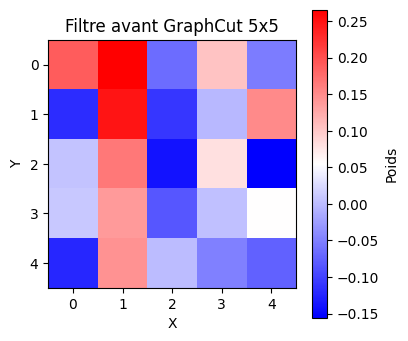

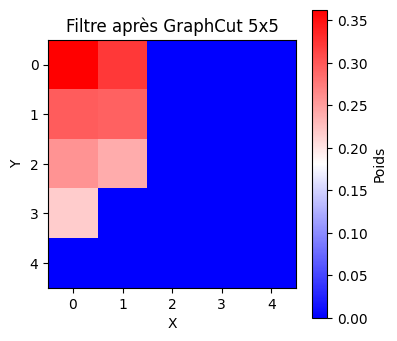

In [21]:
import numpy as np

import numpy as np

def project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max'):
    """
    Projette une surface Zcut + mask sur une grille kernel_size x kernel_size
    en gardant la valeur maximale ou moyenne des zones conservées dans chaque bloc.

    Zcut : surface lissée après GraphCut (2D numpy array)
    mask : masque booléen correspondant aux zones conservées (même taille que Zcut)
    kernel_size : taille de la grille cible (ex: 5 pour 5x5)
    method : 'max' ou 'mean' pour résumer chaque bloc

    Retour : kernel_values 5x5 avec 0 pour les zones à supprimer et la valeur projetée ailleurs
    """
    assert Zcut.shape == mask.shape, "Zcut et mask doivent avoir la même taille"

    h_smooth, w_smooth = Zcut.shape
    block_h = h_smooth // kernel_size
    block_w = w_smooth // kernel_size
    kernel_values = np.zeros((kernel_size, kernel_size))

    for i in range(kernel_size):
        for j in range(kernel_size):
            block = Zcut[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_mask = mask[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block_filtered = block * block_mask  # met à zéro les zones faibles

            if method == 'max':
                kernel_values[i,j] = np.max(block_filtered)
            elif method == 'mean':
                # on prend la moyenne des valeurs non nulles
                values = block_filtered[block_filtered != 0]
                kernel_values[i,j] = np.mean(values) if len(values) > 0 else 0
            else:
                raise ValueError("method doit être 'max' ou 'mean'")

    return kernel_values


kernel_mask_5x5 = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='max')

# Zcut et mask obtenus après GraphCut
def show_filter(matrix_5, title="Filtre 2D"):
    """
    Affiche une matrice 5x5 (ou n×n) en 2D avec une colormap rouge/bleu.
    """
    plt.figure(figsize=(4,4))
    plt.imshow(matrix_5, cmap='bwr', interpolation='nearest')
    plt.colorbar(label='Poids')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
# matrix_5 : ton kernel 5x5 après GraphCut
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
# Par exemple, la 2ème couche Conv2d
conv_layer = conv_layers[0]
W = conv_layer.weight.data.cpu().numpy()
filter_weights = W[2,0]
matrix_5 = filter_weights
show_filter(matrix_5, title="Filtre avant GraphCut 5x5")
show_filter(kernel_mask_5x5, title="Filtre après GraphCut 5x5")

In [22]:
kernel_values_5x5 = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=5, method='mean')

print("Kernel 5x5 avec valeurs projetées :\n", kernel_values_5x5)
print("\n")
print(matrix_5)

Kernel 5x5 avec valeurs projetées :
 [[0.30085867 0.27443923 0.         0.         0.        ]
 [0.25792051 0.25278365 0.         0.         0.        ]
 [0.23478409 0.2278492  0.         0.         0.        ]
 [0.2178374  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


[[ 1.89821094e-01  2.65651077e-01 -6.64577037e-02  1.03453740e-01
  -5.31780049e-02]
 [-1.19054444e-01  2.47875750e-01 -1.10907912e-01 -3.00001958e-03
   1.51757121e-01]
 [ 6.75935438e-03  1.66024014e-01 -1.40889198e-01  8.12504441e-02
  -1.55747235e-01]
 [ 9.40973032e-03  1.38369620e-01 -8.49648118e-02  3.83600127e-03
   5.64241186e-02]
 [-1.23776145e-01  1.44793615e-01 -1.09432585e-04 -4.90716100e-02
  -7.43627697e-02]]


In [24]:
def filter_importance_graphcut(weights, percentile=80, kernel_size=5, method="extreme"):
    # GraphCut
    Zcut, mask = graphcut_filter_surface(weights, percentile=percentile)

    # importance = proportion d’énergie conservée après graphcut
    energy_before = np.sum(np.abs(weights))
    energy_after = np.sum(np.abs(Zcut * mask))
    importance = energy_after / (energy_before + 1e-8)

    return importance


In [26]:
import copy
import numpy as np
import torch

# Créer une copie complète du modèle entraîné
model_copy = copy.deepcopy(model)

def filter_importance_graphcut(weights, percentile=80, kernel_size=5, method="extreme"):
    """
    Calcule une importance basée sur le ratio d'énergie avant/après GraphCut.
    Retourne aussi l'énergie totale avant/après.
    """
    # Conversion CPU numpy
    if isinstance(weights, torch.Tensor):
        weights = weights.detach().cpu().numpy()

    # GraphCut
    Zcut, mask = graphcut_filter_surface(weights, percentile=percentile)

    # Projection 5x5
    kernel_values = project_graphcut_to_kernel_values(Zcut, mask, kernel_size=kernel_size, method=method)

    # Importance = proportion d'énergie conservée après GraphCut
    energy_before = np.sum(np.abs(weights))
    energy_after = np.sum(np.abs(kernel_values))
    importance = energy_after / (energy_before + 1e-8)

    return importance, energy_before, energy_after


def mesure_filter_importance(model, smooth_factor=50, percentile=90, kernel_size=5,
                             method='extreme', small_threshold=0.0, save_sparse=True):
    """
    Applique le pipeline GraphCut + projection 5x5 à toutes les Conv2d du modèle.
    Retourne trois dictionnaires :
      - L : importance basée sur GraphCut
      - M : importance brute (somme des poids absolus)
      - V : variance des poids par filtre
    """
    L = {}
    M = {}
    V = {}
    device = next(model.parameters()).device

    # Créer une liste uniquement des modules Conv2d
    conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]
    for m_idx, m in enumerate(conv_layers):
        L[m_idx], M[m_idx], V[m_idx] = {}, {}, {}
        with torch.no_grad():
            out_channels, in_channels, h, w = m.weight.shape
            for oc in range(out_channels):
                L[m_idx][oc], M[m_idx][oc], V[m_idx][oc] = {}, {}, {}
                for ic in range(in_channels):
                    filter_weights = m.weight[oc, ic].cpu().numpy()

                    # Importance basée sur GraphCut
                    importance_graphcut, energy_before, energy_after = filter_importance_graphcut(
                        filter_weights,
                        percentile=percentile,
                        kernel_size=kernel_size,
                        method=method
                    )
                    L[m_idx][oc][ic] = float(importance_graphcut)

                    # Importance brute (somme des poids absolus)
                    importance_abs = float(np.sum(np.abs(filter_weights)))
                    M[m_idx][oc][ic] = importance_abs

                    # Variance des poids
                    variance = float(np.var(filter_weights))
                    V[m_idx][oc][ic] = variance

    return L, M, V


def evaluate_model(model, val_dl, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item() * x.size(0)
            total_correct += (pred.argmax(1) == y).sum().item()
            total_samples += x.size(0)
    return total_loss / total_samples, total_correct / total_samples


# ---- Exemple d'utilisation ----

# Mesurer l'importance des filtres
L, M, V = mesure_filter_importance(
    model_copy,
    smooth_factor=50,
    percentile=80,
    kernel_size=5,
    method='mean',
    small_threshold=0.01,
    save_sparse=True
)

# Évaluer le modèle transformé
val_loss, val_acc = evaluate_model(model_copy, val_dl, loss_fn)
print(f"Validation Loss après GraphCut: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# Exemple : accéder à une couche, filtre, canal
print("Importance GraphCut du filtre (couche 0, out=0, in=0):", L[0][0][0])
print("Importance brute (abs sum) du filtre (couche 0, out=0, in=0):", M[0][0][0])
print("Variance du filtre (couche 0, out=0, in=0):", V[0][0][0])


Validation Loss après GraphCut: 0.2780, Accuracy: 0.9077
Importance GraphCut du filtre (couche 0, out=0, in=0): 0.3892522077045824
Importance brute (abs sum) du filtre (couche 0, out=0, in=0): 2.3795371055603027
Variance du filtre (couche 0, out=0, in=0): 0.012695197947323322


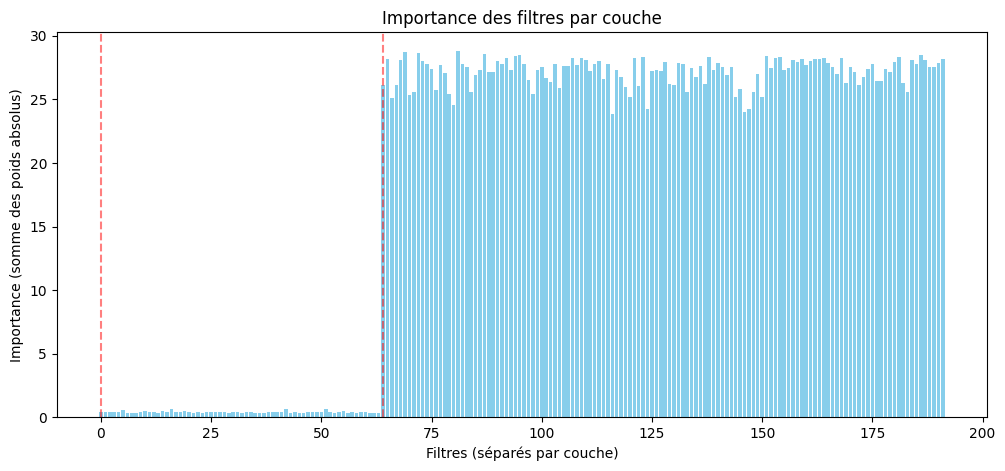

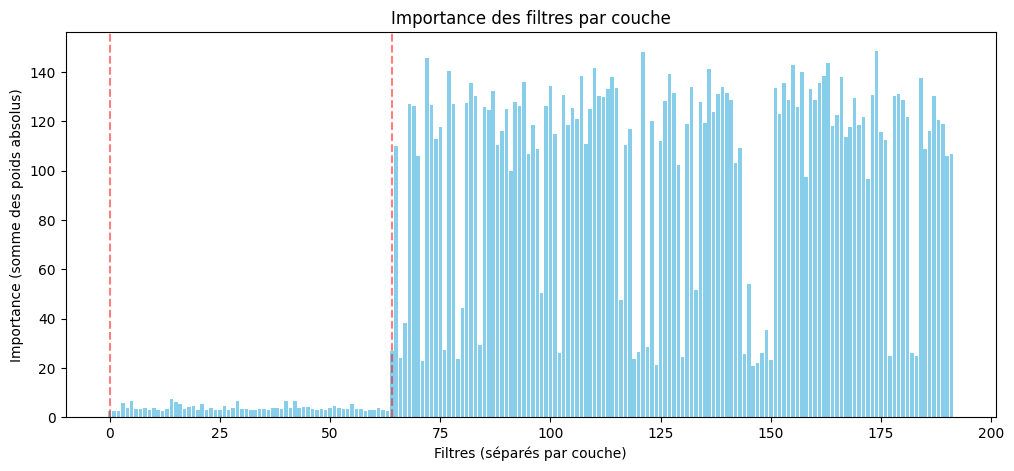

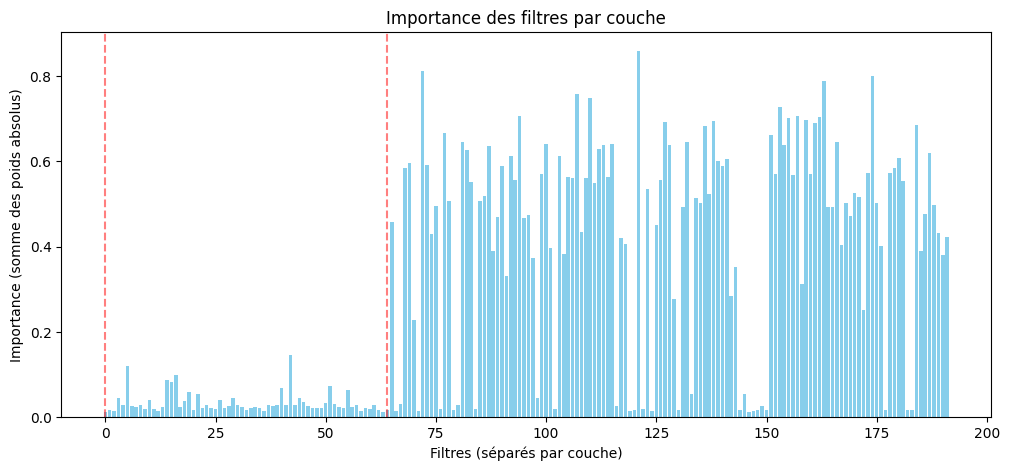

In [27]:
import matplotlib.pyplot as plt

def plot_filter_importance(importance_dict):
    """
    importance_dict[conv_layer_idx][out_channel][in_channel] = importance
    Affiche l'importance de chaque filtre par couche sur un même graphe.
    """
    x_vals = []
    y_vals = []
    labels = []

    # parcourir chaque couche et filtre
    for layer_idx, layer in importance_dict.items():
        for out_ch, out_dict in layer.items():
            # sommer sur les canaux d'entrée pour chaque filtre
            importance = sum(out_dict.values())
            x_vals.append(len(x_vals))  # position sur l'axe x
            y_vals.append(importance)
            labels.append(f"L{layer_idx}")  # annoter la couche

    plt.figure(figsize=(12,5))
    plt.bar(x_vals, y_vals, color='skyblue')

    # ajouter des séparateurs pour les couches
    cum_idx = 0
    for layer_idx, layer in importance_dict.items():
        plt.axvline(x=cum_idx, color='r', linestyle='--', alpha=0.5)
        cum_idx += len(layer)

    plt.xlabel("Filtres (séparés par couche)")
    plt.ylabel("Importance (somme des poids absolus)")
    plt.title("Importance des filtres par couche")
    plt.show()
plot_filter_importance(L)
plot_filter_importance(M)
plot_filter_importance(V)

In [28]:
def top_decile_filter_indices(importance_dict, top_fraction=0.1):
    """
    Retourne les indices des filtres les plus importants.

    Args:
        importance_dict (dict): dict[layer][out_ch][in_ch] = importance
        top_fraction (float): fraction à conserver (0.1 = top 10%)

    Returns:
        indices (list of tuples): [(layer_idx, out_ch, in_ch), ...]
        threshold (float): valeur d'importance minimale pour entrer dans le top
    """
    # Aplatir toutes les importances avec leurs indices
    all_items = []
    for layer_idx, layer in importance_dict.items():
        for out_ch, out_dict in layer.items():
            for in_ch, imp in out_dict.items():
                all_items.append((layer_idx, out_ch, in_ch, imp))

    # Calculer le seuil du top fraction
    all_importances = np.array([imp for _, _, _, imp in all_items])
    threshold = np.percentile(all_importances, 100 * (1 - top_fraction))

    # Sélectionner uniquement les filtres au-dessus du seuil
    top_indices = [(l, o, i) for l, o, i, imp in all_items if imp >= threshold]

    return top_indices, threshold




In [37]:
import torch
import torch.nn as nn
import copy
model_copy = copy.deepcopy(model)
def prune_model_by_top_indices(model, top_indices_list):
    """
    Prune les filtres d'un modèle nn.Sequential en conservant uniquement les filtres listés
    dans top_indices_list = [(layer_idx, out_ch, in_ch), ...]

    Cette fonction reconstruit le modèle pour que chaque Conv2d ait le bon in_channels.
    """
    model = copy.deepcopy(model)

    # Créer un mapping layer_idx -> liste de filtres à conserver
    from collections import defaultdict
    layer_to_out_channels = defaultdict(list)
    for l, o, _ in top_indices_list:
        if o not in layer_to_out_channels[l]:
            layer_to_out_channels[l].append(o)

    # Reconstruire les Conv2d prunés
    layers = []
    prev_out_channels = None
    conv_idx = 0

    for i, m in enumerate(model):
        if isinstance(m, nn.Conv2d):
            keep_out_channels = layer_to_out_channels.get(conv_idx, list(range(m.out_channels)))

            # Si c'est la première couche, garder les in_channels d'origine
            if prev_out_channels is None:
                new_in_channels = m.in_channels
            else:
                new_in_channels = prev_out_channels  # s'adapte à la couche précédente

            new_out_channels = len(keep_out_channels)

            # Créer la nouvelle Conv2d
            new_conv = nn.Conv2d(new_in_channels, new_out_channels, m.kernel_size,
                                 stride=m.stride, padding=m.padding, bias=(m.bias is not None))

            # Copier les poids des filtres conservés
            with torch.no_grad():
                for new_idx, old_idx in enumerate(keep_out_channels):
                    if prev_out_channels is None:
                        new_conv.weight[new_idx] = m.weight[old_idx]
                    else:
                        # Ajuster les in_channels si nécessaire
                        new_conv.weight[new_idx, :prev_out_channels] = m.weight[old_idx, :prev_out_channels]
                    if m.bias is not None:
                        new_conv.bias[new_idx] = m.bias[old_idx]

            layers.append(new_conv)
            prev_out_channels = new_out_channels
            conv_idx += 1
        else:
            # Pour les autres couches (ReLU, MaxPool, Flatten, Linear...), ajouter directement
            layers.append(copy.deepcopy(m))

    # Recréer le modèle Sequential
    pruned_model = nn.Sequential(*layers)
    return pruned_model
top_indices, _ = top_decile_filter_indices(L, top_fraction=0.8)  # top 50%
model_pruned = prune_model_by_top_indices(model, top_indices)

# Vérifier
from torchsummary import summary
summary(model_pruned, (1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 35, 24, 24]          910
├─MaxPool2d: 1-2                         [-1, 35, 12, 12]          --
├─ReLU: 1-3                              [-1, 35, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           112,128
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 640,152
Trainable params: 640,152
Non-trainable params: 0
Total mult-adds (M): 8.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 2.44
Estimated Total Size (MB): 2.6

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 35, 24, 24]          910
├─MaxPool2d: 1-2                         [-1, 35, 12, 12]          --
├─ReLU: 1-3                              [-1, 35, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           112,128
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 640,152
Trainable params: 640,152
Non-trainable params: 0
Total mult-adds (M): 8.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 2.44
Estimated Total Size (MB): 2.6

In [32]:
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─MaxPool2d: 1-2                         [-1, 64, 12, 12]          --
├─ReLU: 1-3                              [-1, 64, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           204,928
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 733,706
Trainable params: 733,706
Non-trainable params: 0
Total mult-adds (M): 14.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.80
Estimated Total Size (MB): 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─MaxPool2d: 1-2                         [-1, 64, 12, 12]          --
├─ReLU: 1-3                              [-1, 64, 12, 12]          --
├─Conv2d: 1-4                            [-1, 128, 8, 8]           204,928
├─MaxPool2d: 1-5                         [-1, 128, 4, 4]           --
├─ReLU: 1-6                              [-1, 128, 4, 4]           --
├─Flatten: 1-7                           [-1, 2048]                --
├─Linear: 1-8                            [-1, 256]                 524,544
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 733,706
Trainable params: 733,706
Non-trainable params: 0
Total mult-adds (M): 14.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 2.80
Estimated Total Size (MB): 

In [38]:
import torch

def test_model(model, test_dl, loss_fn):
    """
    Évalue le modèle sur un DataLoader de test.

    Args:
        model (torch.nn.Module): modèle PyTorch
        test_dl (DataLoader): DataLoader pour le test
        loss_fn: fonction de perte (ex: nn.CrossEntropyLoss())

    Returns:
        test_loss (float): perte moyenne sur le test
        test_acc (float): accuracy sur le test
    """
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            total_loss += loss.item() * x.size(0)
            total_correct += (pred.argmax(dim=1) == y).sum().item()
            total_samples += x.size(0)

    test_loss = total_loss / total_samples
    test_acc = total_correct / total_samples
    return test_loss, test_acc


In [40]:
test_loss, test_acc = test_model(model_pruned,val_dl , loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 2.0217, Test Accuracy: 0.2340
